In [7]:
### GENERAL REQUIREMENTS - will install the libraries

import pandas as pd
import numpy as np
import math
import nltk
import requests
import re
import json
import io
import time # to avoid errors, we sometime use time.sleep(N) before retrying a request
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import geopandas

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

import sddk



In [2]:
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [21]:
# read the datasets
publicfolder = "e0f9cd400dd05584fe06fe1d804deff0"
EDH = sddk.read_file("EDH_occupsorgs_2021-02-26.json", "df", publicfolder)
EDCS = sddk.read_file("EDCS_occupsorgs_2021-02-26.json", "df", publicfolder)

reading file located in a public folder
reading file located in a public folder


In [108]:
# EDH as a geodataframe
EDHg = EDH[EDH["coordinates"].apply(lambda x: isinstance(x, list))]
EDHg = geopandas.GeoDataFrame(EDHg, geometry=geopandas.points_from_xy(EDHg["coordinates"].apply(lambda x: x[0]), EDHg["coordinates"].apply(lambda x: x[1])), crs={'init' :'epsg:4806'})

In [3]:
# read hanson's cities
cities_pop = sddk.read_file("SDAM_data/urban/roman_cities.json", "df", conf)

In [5]:
cities_pop.head(5)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Longitude (X),...,Select Bibliography,Area,Estimate Basis,Civic Status,Structure,num_of_structures,ID,pop_sample,pop_est,pop_diff
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,22.933333,...,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,16.0,Walls,[Rights and privileges],"[Acropolis, Agora, Temple of Apollo, Theatre, ...",5,1,NaN,1700.0,NaN
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,23.734088,...,BNP; DGRG; PECS; Sear 2006.,NaN,None,None,"[Sanctuary of Apollo Argyieus, Sanctuary of He...",3,2,NaN,1000.0,NaN
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,23.219702,...,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,NaN,None,None,"[Acropolis, Agora, Fountain, Temple of Apollo ...",7,3,NaN,1000.0,NaN
3,Hanson2016_4,Aegina,Aigina,Achaea,Greece,2,59 A3,-600,NaN,23.428500,...,BNP; DGRG; Hansen 2006; Hansen and Nielsen 200...,52.0,Inhabited area,[Rights and privileges],"[Shrine of Aeacus, Stadium, Temple of Aphrodit...",8,4,NaN,8209.0,NaN
4,Hanson2016_5,Aegira,Aigeira,Achaea,Greece,3,58 C1,-600,NaN,22.355720,...,DGRG; Hansen and Nielsen 2004.,NaN,None,None,"[Acropolis, Agora, Gymnasium, Temple of Aphrod...",8,5,NaN,1000.0,NaN


In [6]:
cities_pop.columns

Index(['Primary Key', 'Ancient Toponym', 'Modern Toponym', 'Province',
       'Country', 'Barrington Atlas Rank', 'Barrington Atlas Reference',
       'Start Date', 'End Date', 'Longitude (X)', 'Latitude (Y)',
       'Select Bibliography', 'Area', 'Estimate Basis', 'Civic Status',
       'Structure', 'num_of_structures', 'ID', 'pop_sample', 'pop_est',
       'pop_diff'],
      dtype='object')

In [105]:
cities_pop = geopandas.GeoDataFrame(cities_pop, geometry=geopandas.points_from_xy(cities_pop["Longitude (X)"], cities_pop["Latitude (Y)"]), crs={'init' :'epsg:4806'})

In [109]:
### # pelagios provinces
url = "https://raw.githubusercontent.com/pelagios/magis-pleiades-regions/main/pleiades-regions-magis-pelagios.geojson"
pleiades_regions = geopandas.read_file(url, crs={'init' :'epsg:4806'})
pleiades_regions.head()

,name,uri,geometry
0,Lusitania,http://pleiades.stoa.org/places/1101,"POLYGON ((-7.31057 37.19663, -7.32457 37.19556..."
1,Byzacena,http://pleiades.stoa.org/places/991345,"MULTIPOLYGON (((11.01815 34.62424, 11.00879 34..."
2,Viennensis,http://pleiades.stoa.org/places/992074,"POLYGON ((4.62344 45.60642, 4.71224 45.60876, ..."
3,Lycia et Pamphylia,http://pleiades.stoa.org/places/981530,"MULTIPOLYGON (((29.62331 36.07470, 29.61295 36..."
4,Savia,http://pleiades.stoa.org/places/991357,"POLYGON ((18.10598 45.77203, 18.10654 45.71079..."


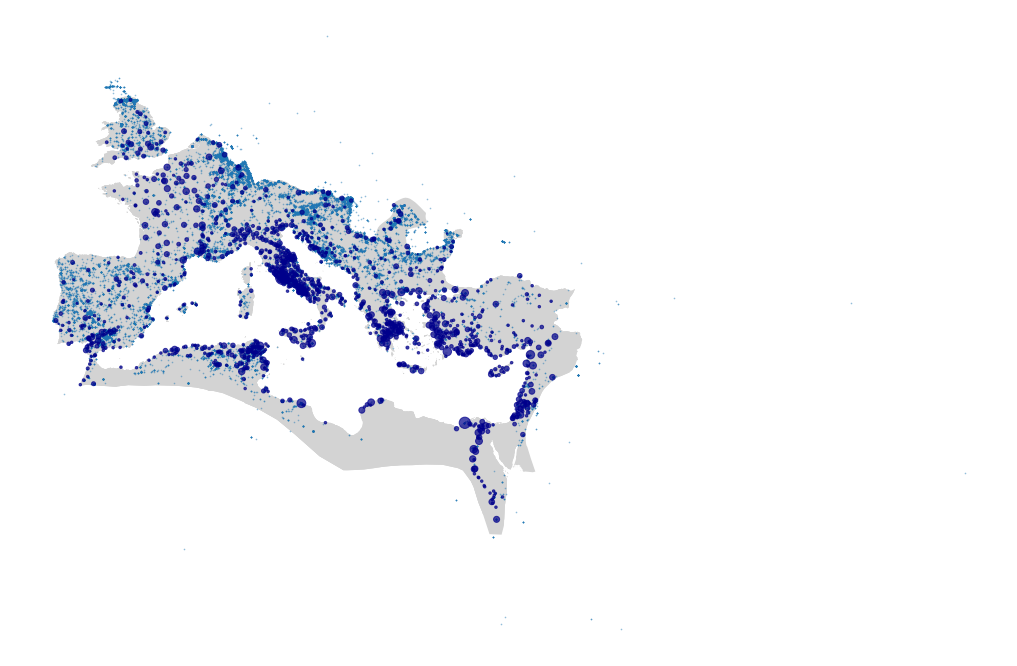

In [110]:
fig, ax = plt.subplots(figsize=[24, 12])
pleiades_regions.plot(ax=ax, color="lightgray")
EDHg.plot(ax=ax, alpha=0.4, markersize=0.5)
cities_pop.plot(markersize=np.sqrt(cities_pop["pop_est"]) / 5, color="darkblue", alpha=0.7, ax=ax)
ax.set_axis_off()

In [111]:
cities_pop.sort_values("pop_est", ascending=False, inplace=True)

In [112]:
len(cities_pop)

1388

In [113]:
cities_pop["pop_est"].sum()

10159670.0

In [114]:
cities_pop["pop_est"][:50].sum()

4059005.0

In [190]:
cities_big = cities_pop[cities_pop["pop_est"] >= 20000]
cities_middle = cities_pop[(cities_pop["pop_est"] < 20000) & (cities_pop["pop_est"] > 5000)]
print("big cities: {0}, middle cities {1}".format(cities_big["pop_est"].sum(), cities_middle["pop_est"].sum()))

big cities: 5696504.0, middle cities 2950098.0


<AxesSubplot:>

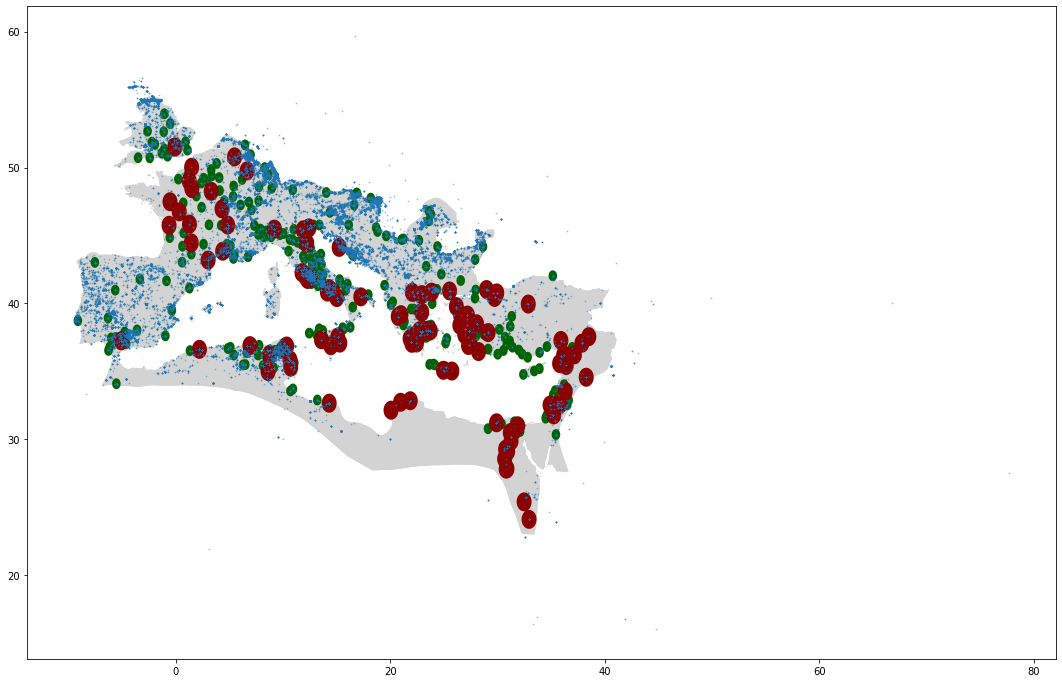

In [202]:
fig, ax = plt.subplots(figsize=[24, 12])
pleiades_regions.plot(ax=ax, color="lightgray")
cities_middle["geometry"].buffer(0.4).plot(ax=ax, color="darkgreen")
cities_big["geometry"].buffer(0.7).plot(ax=ax, color="darkred")
EDHg.plot(ax=ax, alpha=0.4, markersize=0.5)

In [82]:
### some inspiration from here
# https://gis.stackexchange.com/questions/349637/given-list-of-points-lat-long-how-to-find-all-points-within-radius-of-a-give

In [196]:
cities_big_multipolygon = cities_big["geometry"].buffer(0.7).unary_union
cities_middle_multipolygon = cities_middle["geometry"].buffer(0.4).unary_union

In [197]:
EDHg_big_cities = EDHg[EDHg.within(cities_big_multipolygon)]
len(EDHg_big_cities)

20846

In [198]:
big_ids = EDHg_big_cities["id"].tolist() # for filtering

In [199]:
EDHg_middle_cities = EDHg[EDHg.within(cities_middle_multipolygon)]
EDHg_middle_cities = EDHg_middle_cities[~EDHg_middle_cities["id"].isin(big_ids)]  # ) & (not EDHg.within(cities_small_multipolygon))]
len(EDHg_middle_cities)

26124

In [200]:
bigmiddle_ids = big_ids + EDHg_middle_cities["id"].tolist() # for filtering
len(bigmiddle_ids)

46970

In [201]:
EDHg_rural = EDHg[~EDHg["id"].isin(bigmiddle_ids)]
len(EDHg_rural)

32042

In [203]:
EDHg_big_cities["occups_N"].sum(), EDHg_middle_cities["occups_N"].sum(), EDHg_rural["occups_N"].sum() 

(934, 643, 629)